# Unit test notebook for Fission Fragment 2

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess_refactored import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn

## Plots of length scale and variance by order for different potentials

#### Sets meshes and extracts coefficients from the data for a particular observable and potential

In [2]:
# sets the potential of interest
ScaleScheme = RKE500MeV

In [3]:
# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
#                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
#                      interaction = "np")[:, None]
X_train_tlab = E_to_p(E_lab = np.array([1, 5, 12, 21, 33, 48, 65, 85, 108, 133, 161, 192, 225, 261, 300, 341]), 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
# t_lab_subset = t_lab_input[0::10]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
# X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
X_train_deg = -np.cos(np.radians(np.array([41, 60, 76, 90, 104, 120, 139])))[:, None]
degrees_label = "Negative cosine"

X_deg = degrees_input[:, None]
# degrees_subset = degrees_input[0::10]
degrees_subset = X_train_deg[:, 0]

# extracts data
obs_data_name = "PB"
obs_data = ScaleScheme.get_data(obs_data_name)

Lambda_b_coeffs = 480
mpi_eff_coeffs = 141

# sets reference scale
if obs_data_name == "DSG":
    yref = obs_data[-1, :, :]
else:
    yref = np.ones(np.shape(obs_data)[1:])

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "rawsum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

# extracts coefficients
coeffs_flattened = gm.coefficients(
            np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
            ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
            ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
            orders=ScaleScheme.orders_full)
coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

N3LO: slope = 0.00153651475454284
N3LO: intercept = 0.11019699826234963
N3LO: Lambda_b = 650.8235583442415
N3LO: m_eff = 71.71880252795658

N4LO: slope = 0.0009671143604984249
N4LO: intercept = 0.2244993104352085
N4LO: Lambda_b = 1034.0038788014963
N4LO: m_eff = 232.13315777826682

N4LO+: slope = 0.0009594243332009346
N4LO+: intercept = 0.2393787909879672
N4LO+: Lambda_b = 1042.2916799115283
N4LO+: m_eff = 249.50252219403893



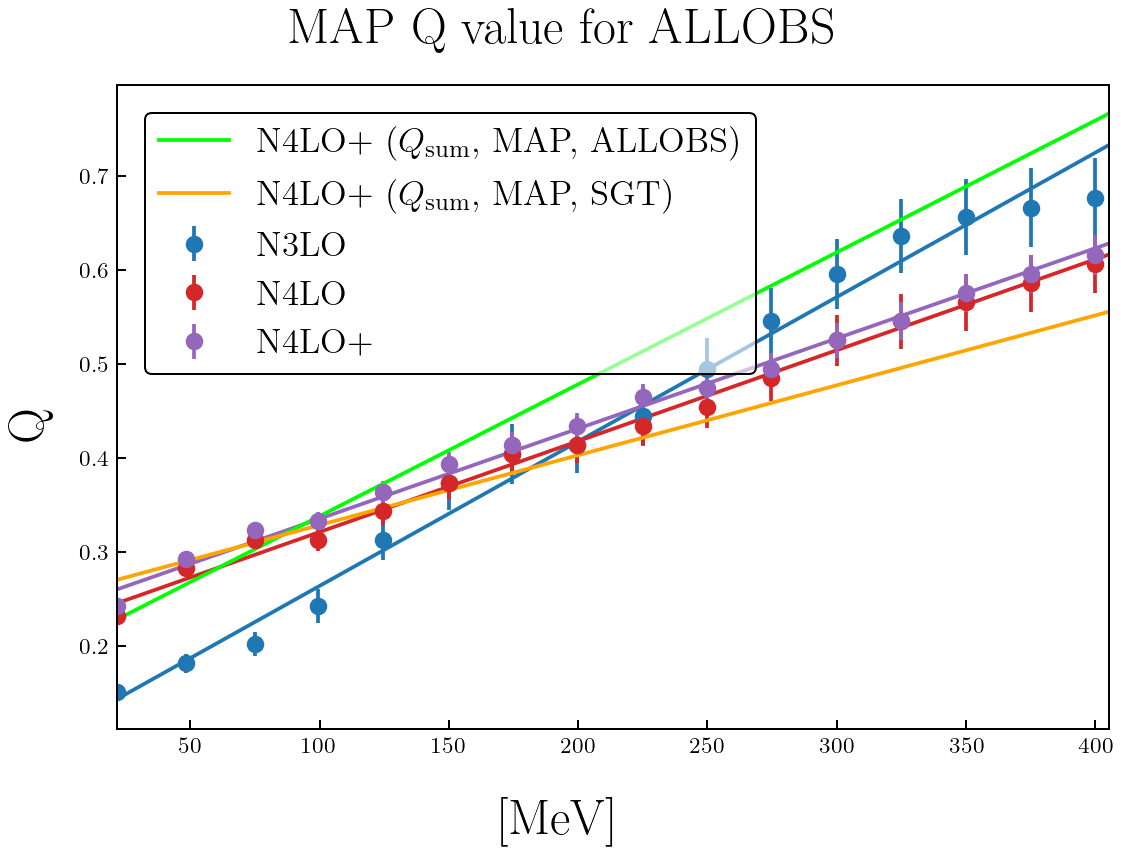

In [15]:
from sklearn.linear_model import LinearRegression

fig_fit, ax_fit = plt.subplots()

Elab_fit_pts = np.array([1, 5, 12, 21, 
                         33, 48, 65, 85, 
                         108, 133, 161, 192, 
                         225, 261, 300, 341])
prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

# Q_fit_pts_n4lop = np.array([0.24232323, 0.2928283, 0.32313132, 0.3332323, 
#                      0.36353534, 0.39383838, 0.41404042, 0.43424243, 
#                      0.46454546, 0.47464648, 0.4948485, 0.5251515, 
#                      0.54535353, 0.5756566, 0.5958586, 0.6160606])
# Q_fit_pts_n4lo = np.array([0.23222223, 0.28272727, 0.3130303, 0.3130303, 
#                      0.34333333, 0.37363636, 0.4039394, 0.41404042, 
#                      0.43424243, 0.45444444, 0.48474747, 0.5251515, 
#                      0.54535353, 0.5655556, 0.58575755, 0.6059596])
# Q_fit_pts_n3lo = np.array([0.15141414, 0.18171717, 0.2019192, 0.24232323, 
#                      0.3130303, 0.37363636, 0.4039394, 0.41404042, 
#                      0.44434345, 0.4948485, 0.54535353, 0.5958586, 
#                      0.63626266, 0.65646464, 0.66656566, 0.6766667])

Q_fit_pts_n3lo = np.array([0.15141414, 0.18171717, 0.2019192, 0.24232323, 
                     0.3130303, 0.37363636, 0.4039394, 0.41404042, 
                     0.44434345, 0.4948485, 0.54535353, 0.5958586, 
                     0.63626266, 0.65646464, 0.66656566, 0.6766667])
Q_fit_stddev_n3lo = np.array([0.008268013038653568, 0.010208874875827981, 0.012379286706742208,
                             0.018043375846022724, 0.02170902393759921, 0.028524159937437496, 
                             0.03210594152221623, 0.030349658001308042, 0.03109650107272273, 
                             0.03309851267059979, 0.0350605136271967, 0.0370637143107644, 
                             0.03920790796923629, 0.040720211698169806, 0.042005877629978504, 
                             0.04284105533733413, ])
Q_fit_pts_n4lo = np.array([0.23222223, 0.28272727, 0.3130303, 0.3130303, 
                     0.34333333, 0.37363636, 0.4039394, 0.41404042, 
                     0.43424243, 0.45444444, 0.48474747, 0.5251515, 
                     0.54535353, 0.5655556, 0.58575755, 0.6059596])
Q_fit_stddev_n4lo = np.array([0.006558852033237524, 0.00878275847449691, 0.010478340334755407,
                             0.012064106956184574, 0.014843179243500435, 0.01766647200093206, 
                             0.019708700709222923, 0.01925189004008597, 0.020617954734779367, 
                             0.022749275168913317, 0.024557711706319502, 0.027555016787715415, 
                             0.02922394729310644, 0.030192086284655507, 0.029964901395776823, 
                             0.029868347123289937, ])
Q_fit_pts_n4lop = np.array([0.24232323, 0.2928283, 0.32313132, 0.3332323, 
                     0.36353534, 0.39383838, 0.41404042, 0.43424243, 
                     0.46454546, 0.47464648, 0.4948485, 0.5251515, 
                     0.54535353, 0.5756566, 0.5958586, 0.6160606])
Q_fit_stddev_n4lop = np.array([0.005804951295539509, 0.007510811095473759, 0.00895770613863829,
                              0.009793964875140655, 0.011492571357070897, 0.01296778678747654, 
                              0.014140166167144284, 0.014000098179504416, 0.014582092061824588, 
                              0.016388006143720643, 0.01696100220590864, 0.0187788217181194, 
                              0.020134251174162596, 0.020472074988986254, 0.020698902103287793, 
                              0.021262632033657677, ])

# a_prel, b_prel = np.polyfit(prel_fit_pts, Q_fit_pts_n3lo, 1)
# print("N3LO: slope = " + str(a_prel))
# print("N3LO: intercept = " + str(b_prel))
# print("N3LO: Lambda_b = " + str(1 / a_prel))
# print("N3LO: m_eff = " + str(b_prel / a_prel) + "\n")
# ax_fit.scatter(prel_fit_pts, Q_fit_pts_n3lo, color = 'blue', label = 'prel (N3LO)')
# ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
#             a_prel * E_to_p(t_lab, interaction = 'np') + b_prel, color = 'blue')
ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n3lo, yerr = Q_fit_stddev_n3lo,
                color = 'tab:blue', label = 'N3LO', fmt = 'o')
model_n3lo = LinearRegression()
model_n3lo.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n3lo, sample_weight=1/Q_fit_stddev_n3lo)
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
            model_n3lo.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:blue')
print("N3LO: slope = " + str(model_n3lo.coef_[0]))
print("N3LO: intercept = " + str(model_n3lo.intercept_))
print("N3LO: Lambda_b = " + str(1 / model_n3lo.coef_[0]))
print("N3LO: m_eff = " + str(model_n3lo.intercept_ / model_n3lo.coef_[0]) + "\n")

# a_prel, b_prel = np.polyfit(prel_fit_pts, Q_fit_pts_n4lo, 1)
# print("N4LO: slope = " + str(a_prel))
# print("N4LO: intercept = " + str(b_prel))
# print("N4LO: Lambda_b = " + str(1 / a_prel))
# print("N4LO: m_eff = " + str(b_prel / a_prel) + "\n")
# ax_fit.scatter(prel_fit_pts, Q_fit_pts_n4lo, color = 'red', label = 'prel (N4LO)')
ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lo, yerr = Q_fit_stddev_n4lo,
                color = 'tab:red', label = 'N4LO', fmt = 'o')
model_n4lo = LinearRegression()
model_n4lo.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n4lo, sample_weight=1/Q_fit_stddev_n4lo)
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
            model_n4lo.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:red')
print("N4LO: slope = " + str(model_n4lo.coef_[0]))
print("N4LO: intercept = " + str(model_n4lo.intercept_))
print("N4LO: Lambda_b = " + str(1 / model_n4lo.coef_[0]))
print("N4LO: m_eff = " + str(model_n4lo.intercept_ / model_n4lo.coef_[0]) + "\n")

# a_prel, b_prel = np.polyfit(prel_fit_pts, Q_fit_pts_n4lop, 1)
# print("N4LO+: slope = " + str(a_prel))
# print("N4LO+: intercept = " + str(b_prel))
# print("N4LO+: Lambda_b = " + str(1 / a_prel))
# print("N4LO+: m_eff = " + str(b_prel / a_prel) + "\n")
# ax_fit.scatter(prel_fit_pts, Q_fit_pts_n4lop, color = 'purple', label = 'prel (N4LO+)')
# ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
#             a_prel * E_to_p(t_lab, interaction = 'np') + b_prel, color = 'purple')
ax_fit.errorbar(prel_fit_pts, Q_fit_pts_n4lop, yerr = Q_fit_stddev_n4lop,
                color = 'tab:purple', label = 'N4LO+', fmt = 'o')
model_n4lop = LinearRegression()
model_n4lop.fit(prel_fit_pts.reshape(-1, 1), Q_fit_pts_n4lop, sample_weight=1/Q_fit_stddev_n4lop)
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
            model_n4lop.predict(E_to_p(t_lab, interaction = 'np').reshape(-1, 1)), color = 'tab:purple')
print("N4LO+: slope = " + str(model_n4lop.coef_[0]))
print("N4LO+: intercept = " + str(model_n4lop.intercept_))
print("N4LO+: Lambda_b = " + str(1 / model_n4lop.coef_[0]))
print("N4LO+: m_eff = " + str(model_n4lop.intercept_ / model_n4lop.coef_[0]) + "\n")

ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
           Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
                   Q_parametrization = 'sum', 
                    Lambda_b = 480, 
                    m_pi = 141), 
            color = 'lime', label = r'N4LO+ ($Q_{\mathrm{sum}}$, MAP, ALLOBS)')
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
           Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
                   Q_parametrization = 'sum', 
                    Lambda_b = 739, 
                    m_pi = 342), 
            color = 'orange', label = r'N4LO+ ($Q_{\mathrm{sum}}$, MAP, SGT)')

fig_fit.suptitle("MAP Q value for ALLOBS", fontsize = 20)
fig_fit.supxlabel("[MeV]", fontsize = 20)
fig_fit.supylabel("Q", fontsize = 20)
ax_fit.legend(fontsize = 14, loc = 'upper left')
fig_fit.tight_layout()

In [5]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

In [6]:
# SGT_data = ScaleScheme.get_data("SGT")
# print(SGT_data)
# DSG_data = ScaleScheme.get_data("DSG")
# radians = degrees * np.pi / 180
# radians_tiled = np.tile(radians, (350, 1))
# radians_tiled = np.tile(radians_tiled, (6, 1, 1))
# print(np.shape(radians_tiled))
# print(radians_tiled)
# print(np.sin(radians_tiled))
# DSG_integr = 2 * np.pi * np.trapz(DSG_data * np.sin(radians_tiled), x = radians, axis = 2)
# print(DSG_integr)
# DSG_simple = 2 * np.pi * np.trapz(DSG_data, x = radians, axis = 2)
# print(DSG_simple)

In [7]:
# # print(SGT_data[-1, :])
# # print(DSG_integr[-1, :])
# fig_integr, ax_integr = plt.subplots()
# ax_integr.plot(t_lab, SGT_data[-1, :])
# ax_integr.plot(t_lab, DSG_integr[-1, :], linestyle = '--', linewidth = 3)
# ax_integr.plot(t_lab, DSG_simple[-1, :], linestyle = ':')
# # ax_integr.plot(t_lab, SGT_data[-1, :] / DSG_integr[-1, :])
# print(SGT_data[-1, :] / DSG_integr[-1, :])

In [8]:
# colors_array = ['orange', 'green', 'blue', 'red', 'purple']

# fig_sgt, ax_sgt = plt.subplots()

# yref_sgt = SGT_data[-1, :]
# print(np.shape(yref_sgt))
# yref_dsg_integr = DSG_integr[-1, :]
# yref_dsg_simple = DSG_simple[-1, :]

# p_grid_sgt = p_approx(p_name = "pprel", 
#                  prel = E_to_p(E_lab = t_lab, interaction = "np"), 
#                  degrees = [0]).T
# print(np.shape(p_grid_sgt))
# ratio_sgt = Q_approx(p = p_grid_sgt, 
#                  Q_parametrization = 'sum', 
# #                  Lambda_b = 725, 
# #                  m_pi = 345,
# #                  Lambda_b = 445, 
# #                  m_pi = 155,
#                  Lambda_b = 550, 
#                  m_pi = 230,
#                  single_expansion=False)
# print(np.shape(ratio_sgt))

# SGT_coeffs = gm.coefficients(
#             SGT_data.T, 
#             ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
#             ref=np.reshape(yref_sgt, np.shape(yref_sgt)[0]), 
#             orders=ScaleScheme.orders_full)
# print(np.shape(SGT_coeffs))
# SGT_coeffs = SGT_coeffs.T

# DSG_integr_coeffs = gm.coefficients(
#             DSG_integr.T, 
#             ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
#             ref=np.reshape(yref_dsg_integr, np.shape(yref_dsg_integr)[0]), 
#             orders=ScaleScheme.orders_full)
# print(np.shape(DSG_integr_coeffs))
# DSG_integr_coeffs = DSG_integr_coeffs.T

# DSG_simple_coeffs = gm.coefficients(
#             DSG_simple.T, 
#             ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
#             ref=np.reshape(yref_dsg_simple, np.shape(yref_dsg_simple)[0]), 
#             orders=ScaleScheme.orders_full)
# print(np.shape(DSG_simple_coeffs))
# DSG_simple_coeffs = DSG_simple_coeffs.T

# for i, curve in enumerate(zip(SGT_coeffs[1:, :], 
#                               DSG_integr_coeffs[1:, :], 
#                               DSG_simple_coeffs[1:, :])):
# #     ax_sgt.plot(t_lab_input, curve[0], color = colors_array[i])
# #     ax_sgt.plot(t_lab_input, curve[1], color = colors_array[i], linewidth = 3, linestyle = '--')
#     ax_sgt.plot(t_lab_input, curve[2], color = colors_array[i], linewidth = 3, linestyle = ':')

#### Plots of total cross section for given $\Lambda_{b}$ and $m_{\text{eff}}$

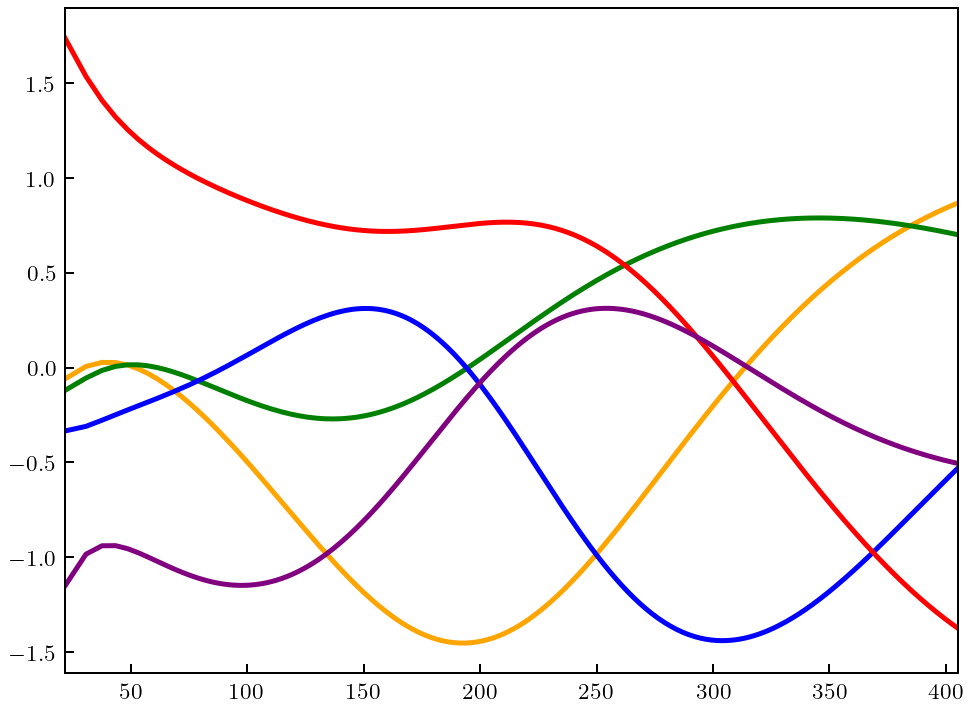

In [9]:
colors_array = ['orange', 'green', 'blue', 'red', 'purple']

fig_sgt, ax_sgt = plt.subplots()

SGT_data = ScaleScheme.get_data("SGT")

p_grid_sgt = p_approx(p_name = "pprel", 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = [0]).T
ratio_sgt = Q_approx(p = p_grid_sgt, 
                 Q_parametrization = 'sum', 
#                  Lambda_b = 725, 
#                  m_pi = 345,
                 Lambda_b = 695, 
                 m_pi = 250,
                 single_expansion=False)

yref_sgt = SGT_data[-1, :]

SGT_coeffs = gm.coefficients(
            SGT_data.T, 
            ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
            ref=np.reshape(yref_sgt, np.shape(yref_sgt)[0]), 
            orders=ScaleScheme.orders_full)
SGT_coeffs = SGT_coeffs.T

# set a limit on x
# print([t > 138 for t in t_lab_input])
t_lab_input_limit = t_lab_input[t_lab_input > 0]

for i, curve in enumerate(SGT_coeffs[1:, :]):
    ax_sgt.plot(t_lab_input_limit, curve[np.isin(t_lab_input, t_lab_input_limit)], 
                color = colors_array[i], linewidth = 2)

#### Plots of scattering-angle length scale and variance by order

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\2750040833.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_ls.flat)[o].scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\2750040833.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping w

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.29034049e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 7, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "


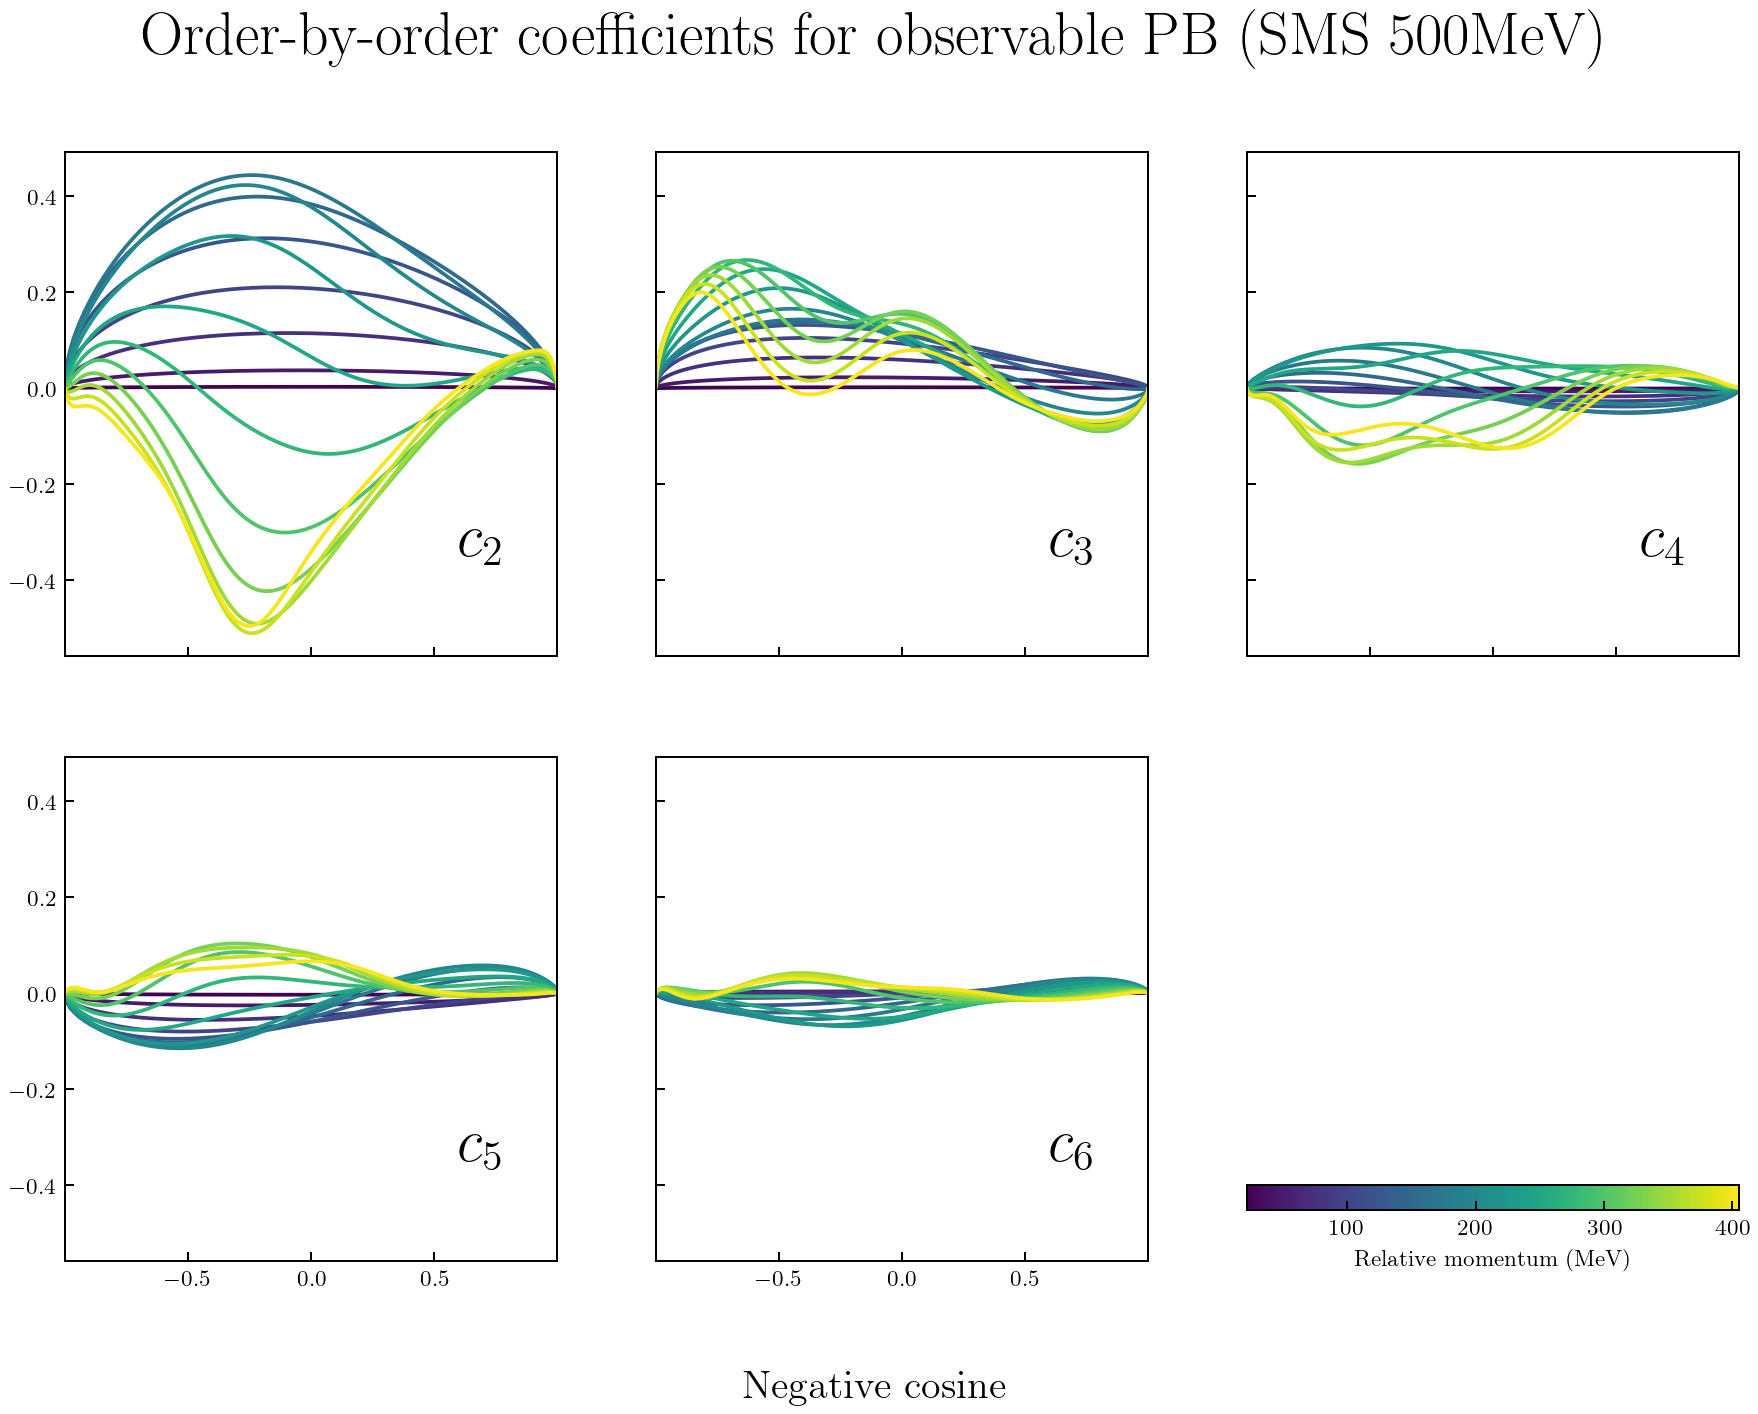

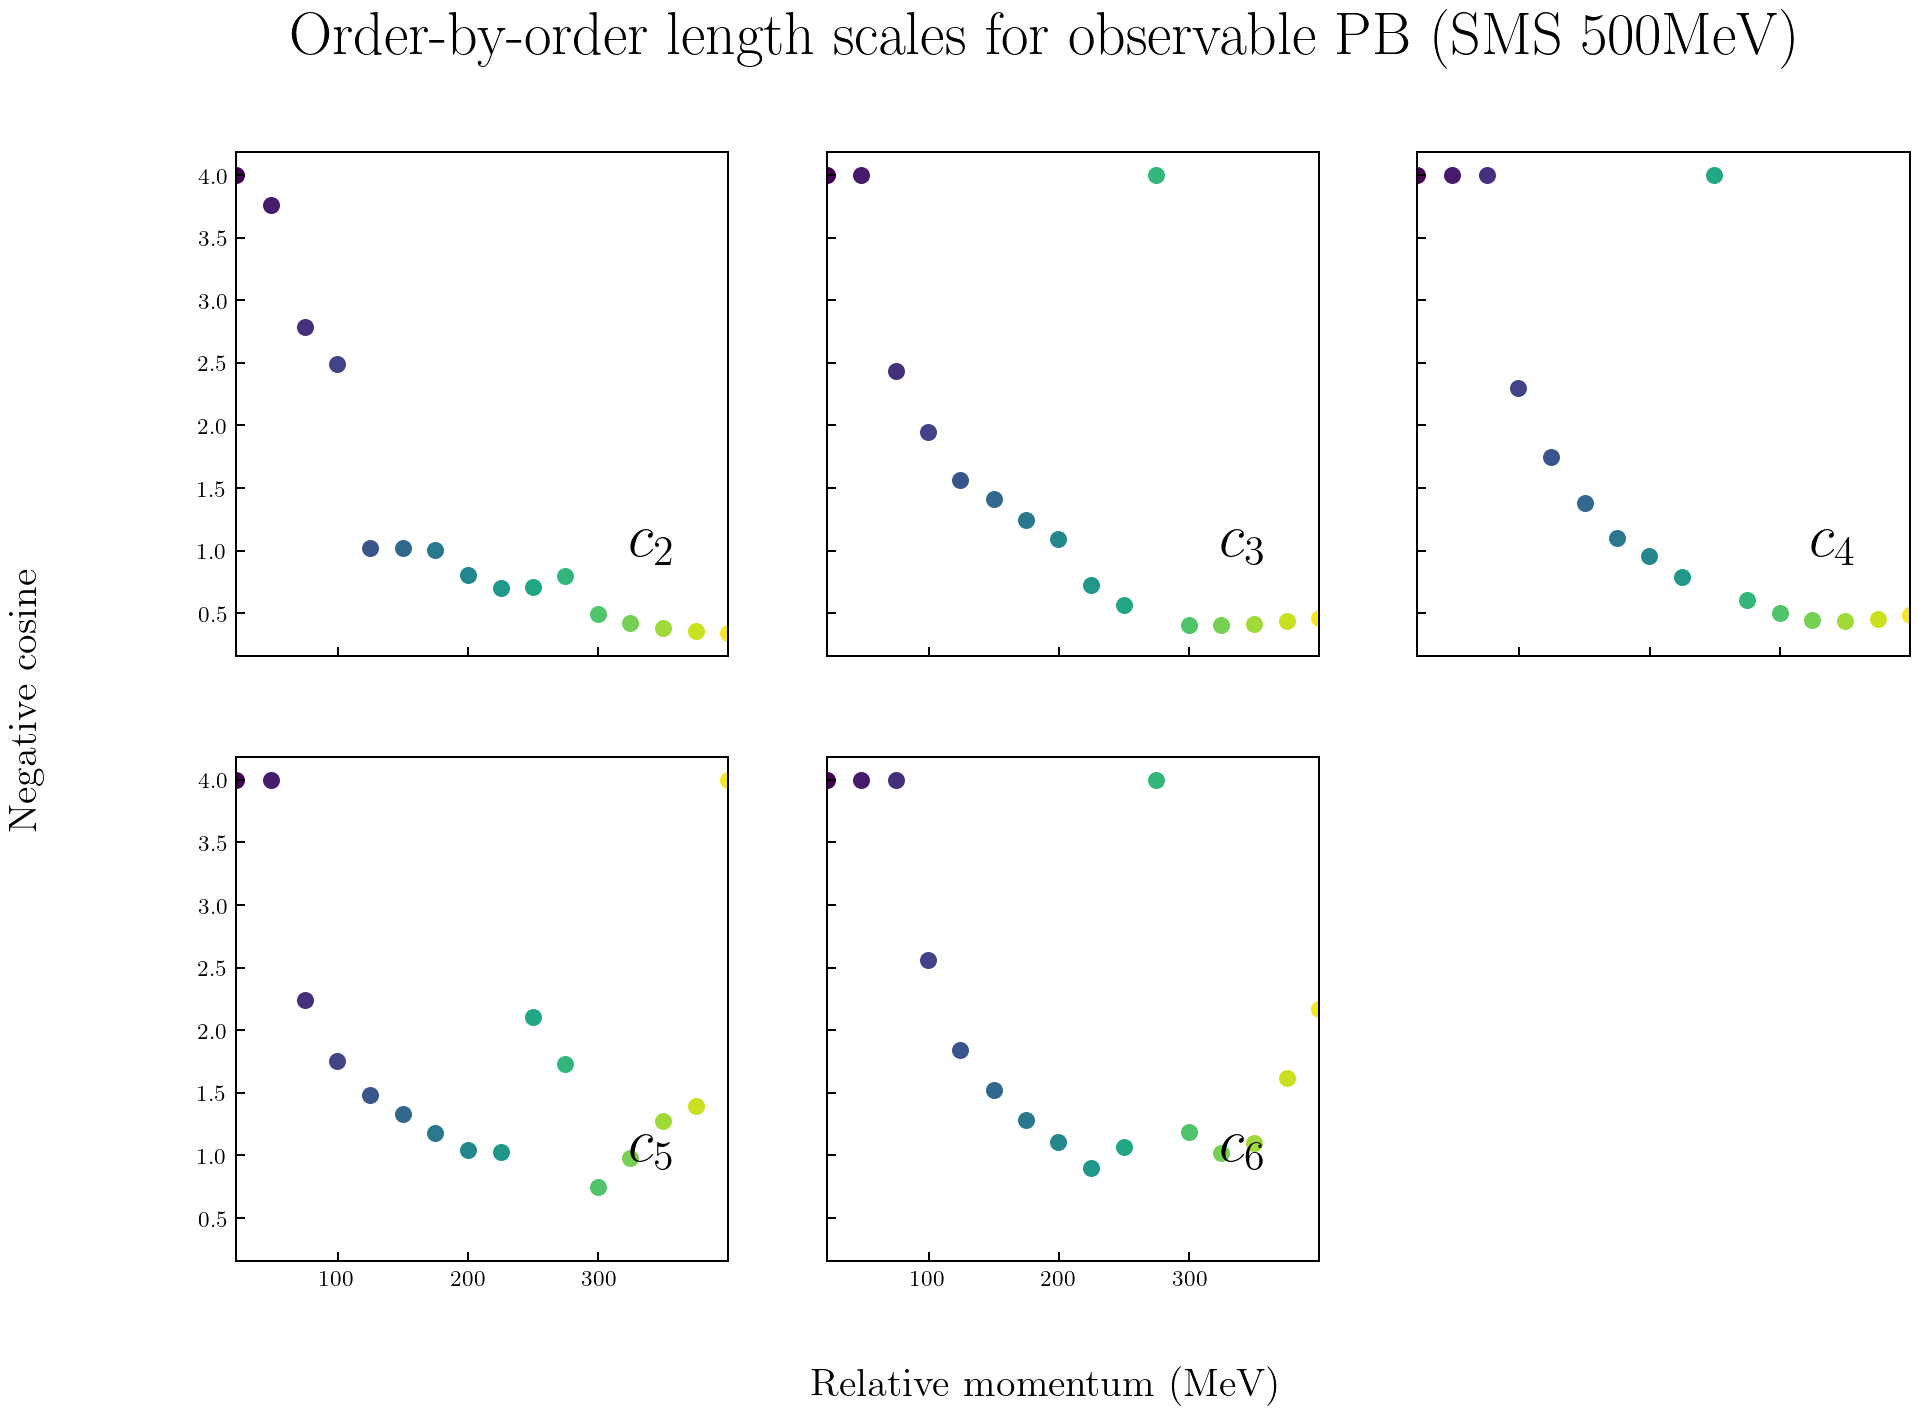

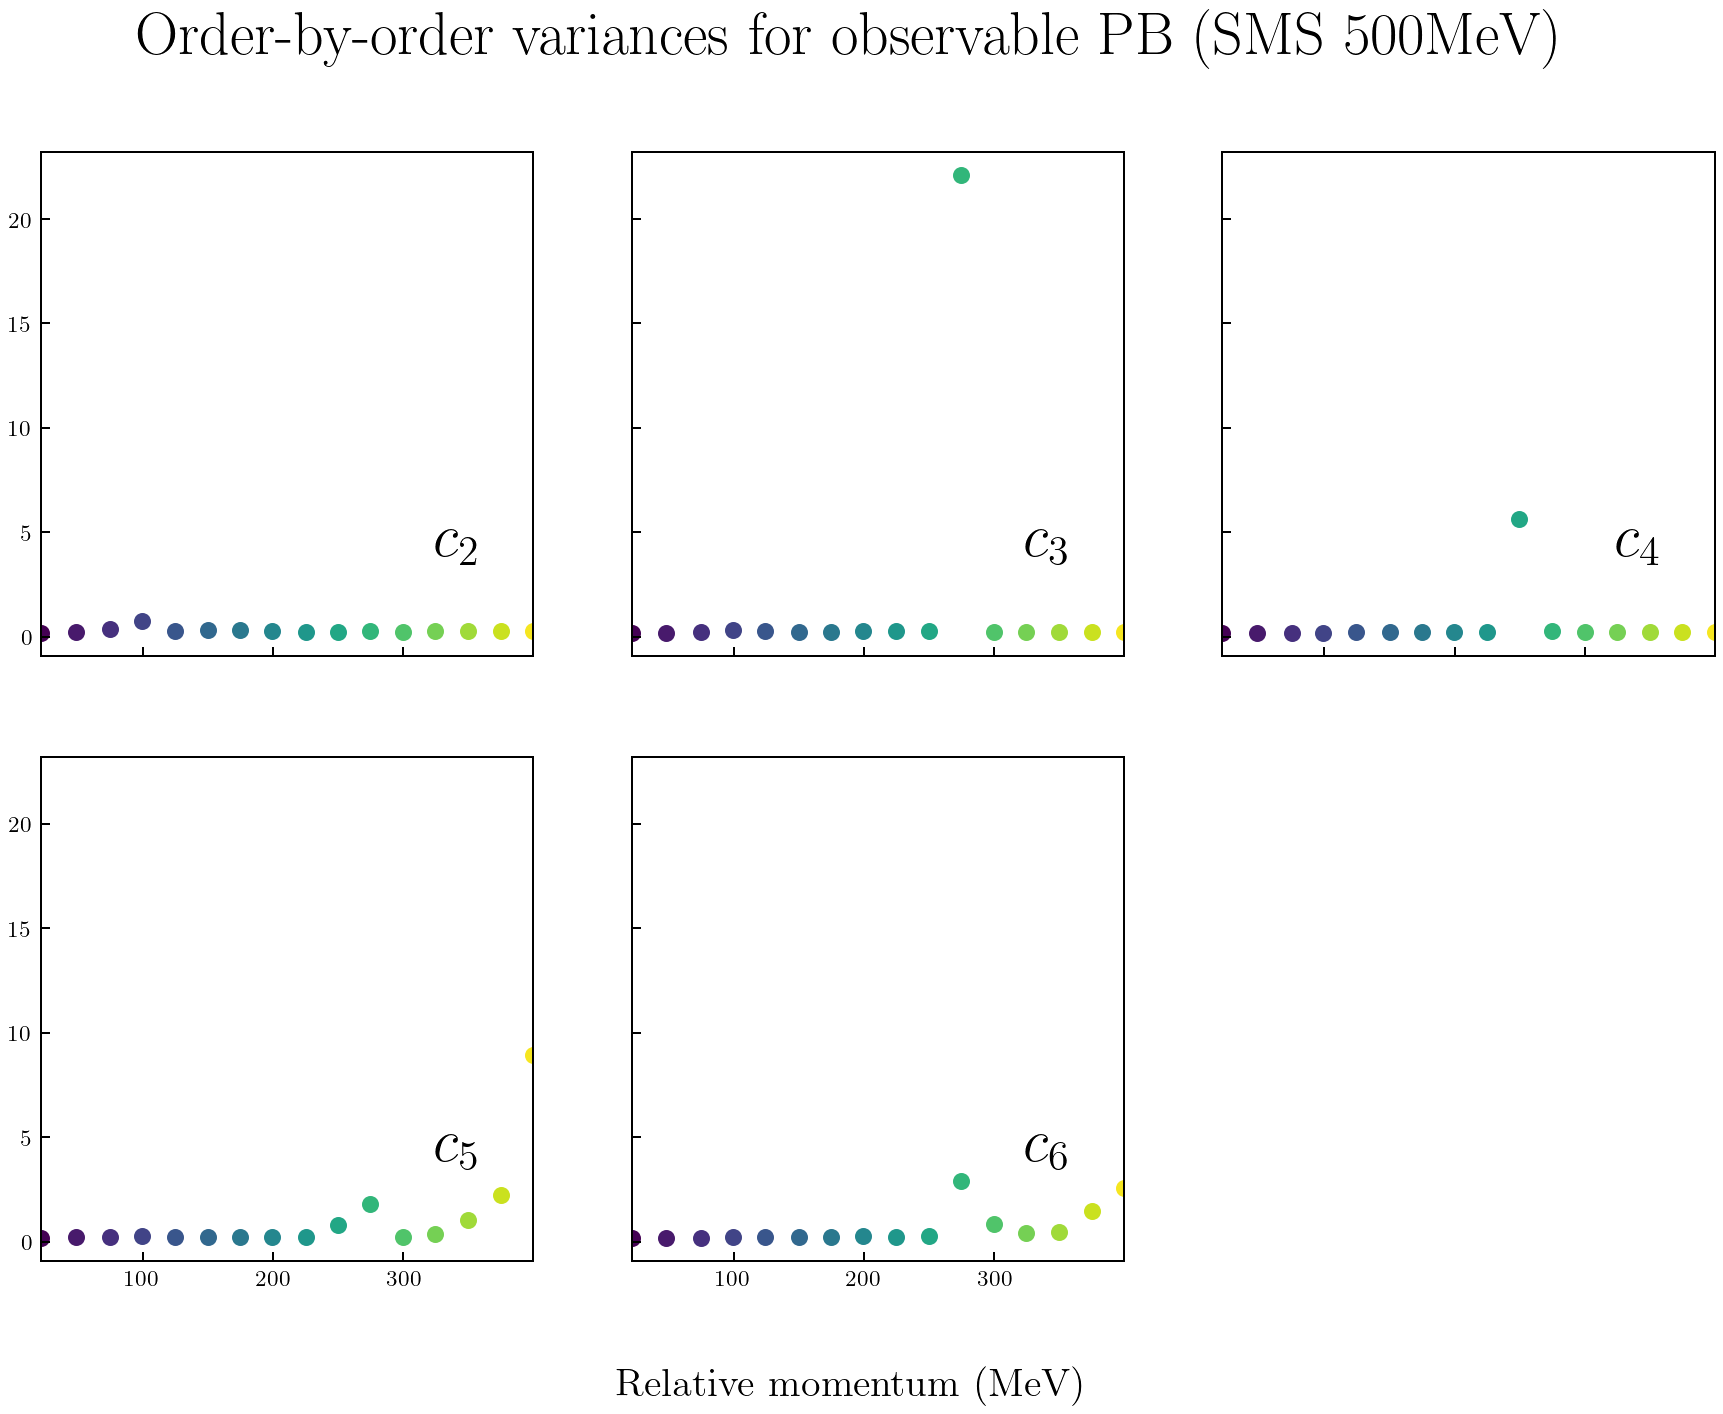

In [10]:
# choose colormap and fix to different energies
cmap_tlab = mpl.cm.viridis
norm_tlab = mpl.colors.Normalize(vmin=np.min(t_lab_input), vmax=np.max(t_lab_input))

# create figure with n_orders subplots
fig_tlab_coeffs, axs_tlab_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_tlab_coeffs.supxlabel(degrees_label, size = 16)
fig_tlab_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_tlab_ls, axs_tlab_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_tlab_ls.supxlabel(t_lab_label, size = 16)
fig_tlab_ls.supylabel(degrees_label, size = 16)
fig_tlab_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_tlab_var, axs_tlab_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_tlab_var.supxlabel(t_lab_label, size = 16)
fig_tlab_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# plot at each energy in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    (axs_tlab_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_coeffs.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_ls.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_ls.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_var.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_var.flat)[o].transAxes, 
                       size = 24)
        
    for t in t_lab_subset:
        (axs_tlab_coeffs.flat)[o].plot(degrees_input, 
                    coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           2 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'),
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               (coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[np.isin(degrees_input, X_train_deg)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_tlab_ls.flat)[o].scatter(t, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_tlab_var.flat)[o].scatter(t, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

fig_tlab_coeffs.delaxes(axs_tlab_coeffs[-1, -1])        
fig_tlab_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab), 
            ax = axs_tlab_coeffs[-1, -1],
             orientation='horizontal', label=t_lab_label)

fig_tlab_ls.delaxes(axs_tlab_ls[-1, -1])
fig_tlab_var.delaxes(axs_tlab_var[-1, -1])

# saves figures
fig_tlab_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_tlab_ls.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_tlab_var.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')

#### Plots of scattering-angle length scale and variance over all orders

C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\724392796.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_ls_all.scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\724392796.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_tlab_var_all.scatter(t,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with

[46.43406911 -0.768341  ]


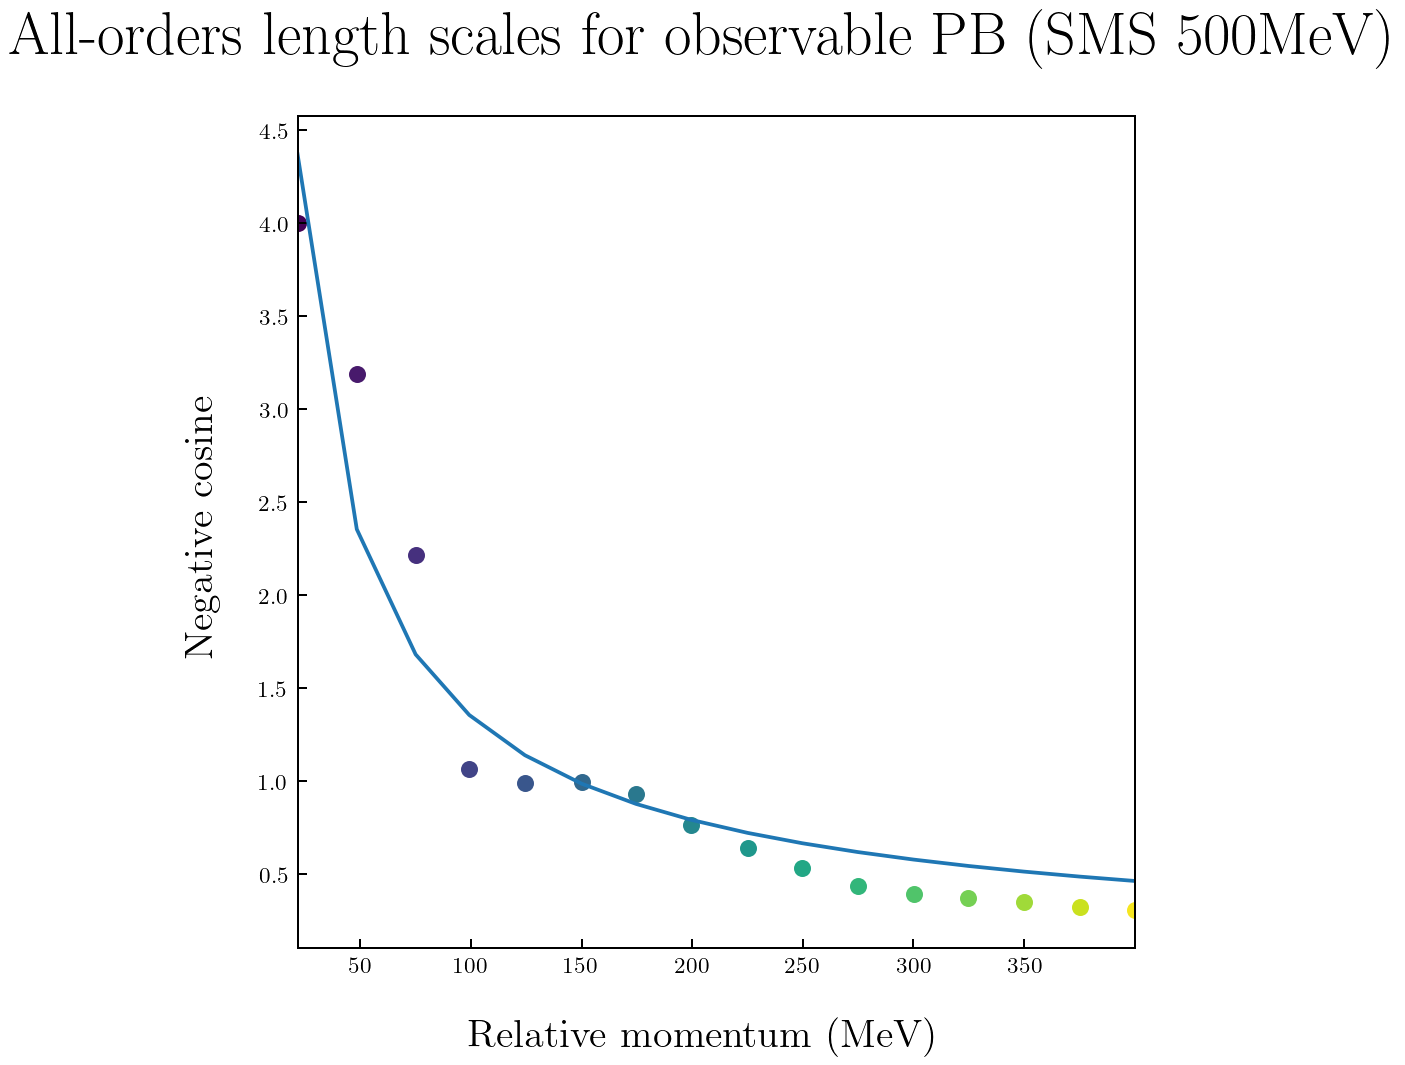

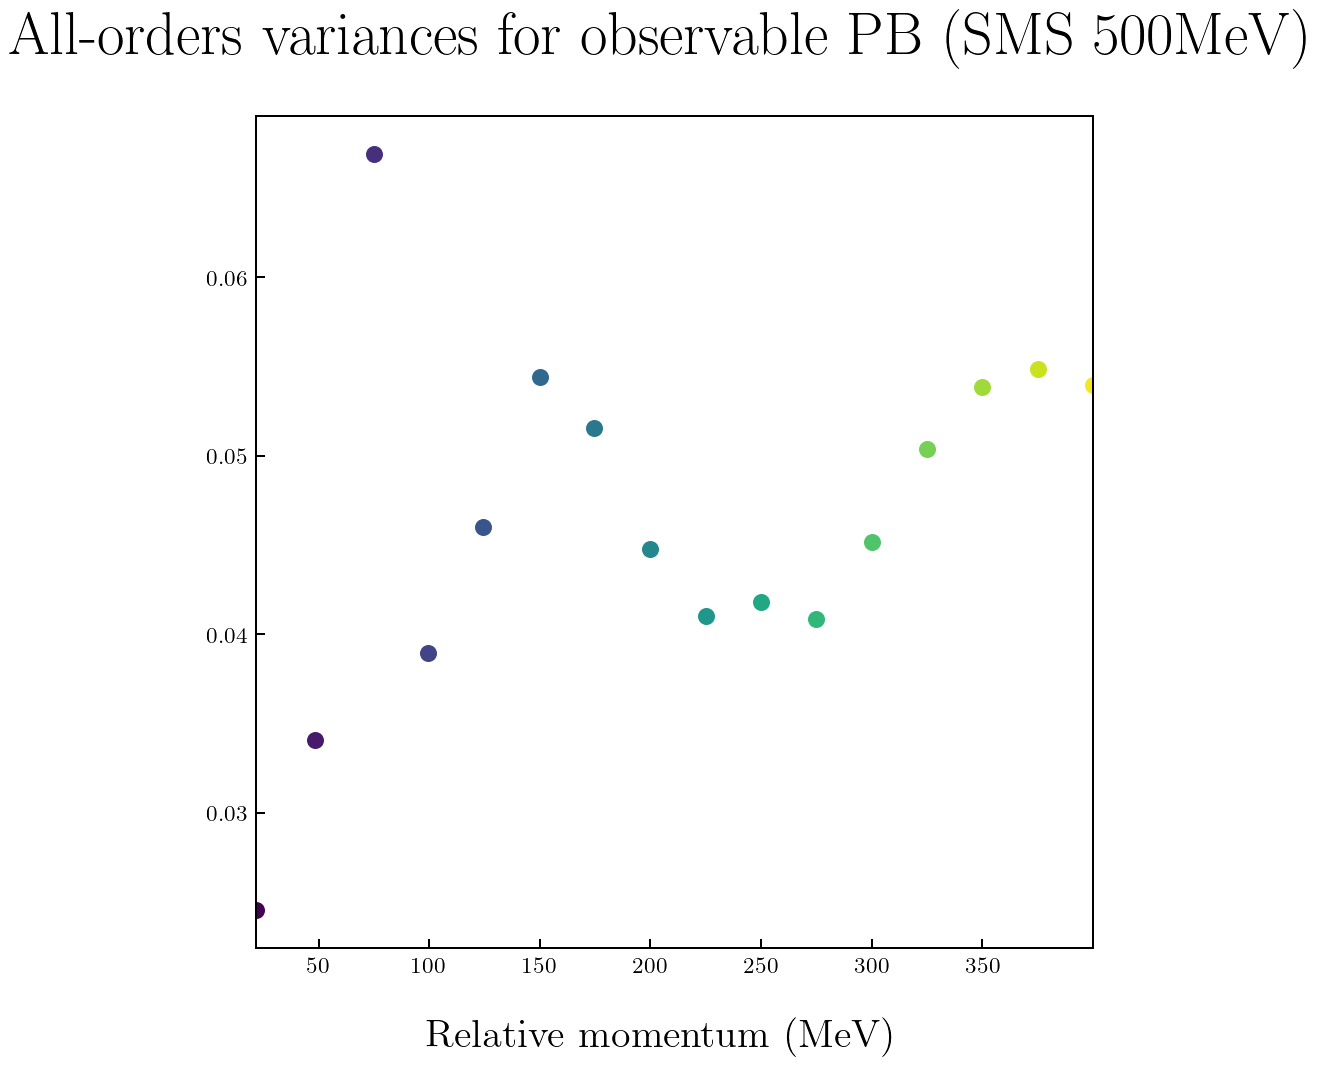

In [11]:
# create figure with n_orders subplots
fig_tlab_ls_all, axs_tlab_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_ls_all.supxlabel(t_lab_label, size = 16)
fig_tlab_ls_all.supylabel(degrees_label, size = 16)
fig_tlab_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_ls_all.semilogx()
# axs_tlab_ls_all.semilogy()

axs_tlab_ls_all_array = np.array([])

# create figure with n_orders subplots
fig_tlab_var_all, axs_tlab_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_var_all.supxlabel(t_lab_label, size = 16)
fig_tlab_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_var_all.semilogx()
# axs_tlab_var_all.semilogy()

# plots at each energy in mesh
for t in t_lab_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           2 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_deg, 
           np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                      (len(degrees), 
                       np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_tlab_ls_all.scatter(t, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
    axs_tlab_ls_all_array = np.append(axs_tlab_ls_all_array, ls_fit)
    pred, std = gp.predict(X_deg, return_std=True)
    underlying_std = gp.cov_factor_
    axs_tlab_var_all.scatter(t, 
                underlying_std, 
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

# sets fitting function and plots the results
def power(x, a, b):
    return a * x**b
def exponent(x, a, b):
    return a * np.exp(b * x)

popt_power, pcov_power = curve_fit(power, t_lab_subset, axs_tlab_ls_all_array)
print(popt_power)
axs_tlab_ls_all.plot(t_lab_subset, power(t_lab_subset, *popt_power))

# popt_exponent, pcov_exponent = curve_fit(exponent, 
#                                          t_lab_subset, 
#                                          axs_tlab_ls_all_array, 
#                                          p0=(241, -0.00846))
# print(popt_exponent)
# axs_tlab_ls_all.plot(t_lab_subset, exponent(t_lab_subset, *popt_exponent))

# saves figures
fig_tlab_ls_all.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_tlab_var_all.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')

#### Plots of lab-energy length scale and variance by order

C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\1161238112.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_ls.flat)[o - 1].scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\1161238112.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_var.flat)[o - 1].scatter(d,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b termin

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.23912293e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.94907875e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 2, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.84633929e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b ter

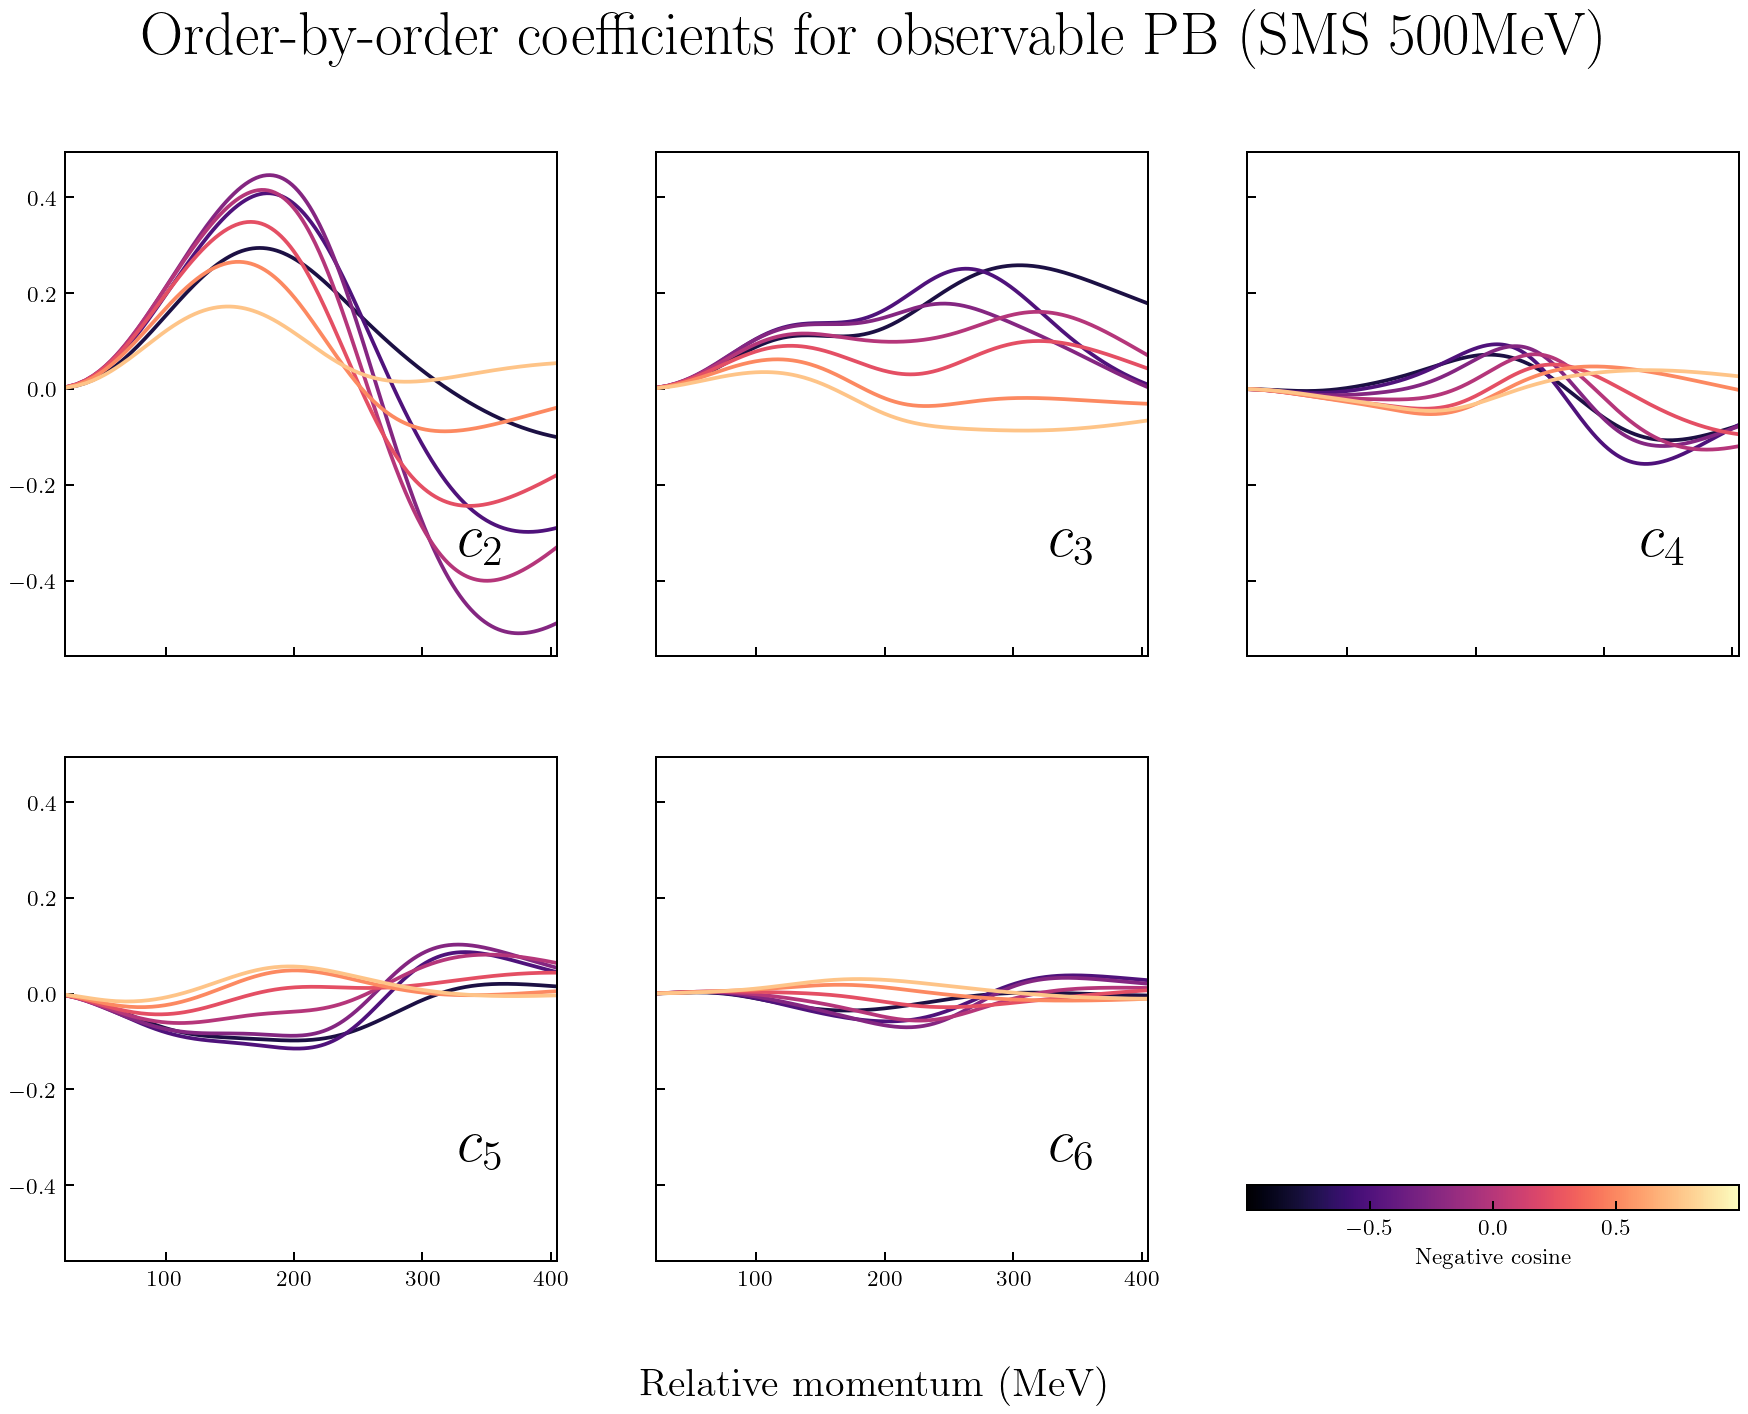

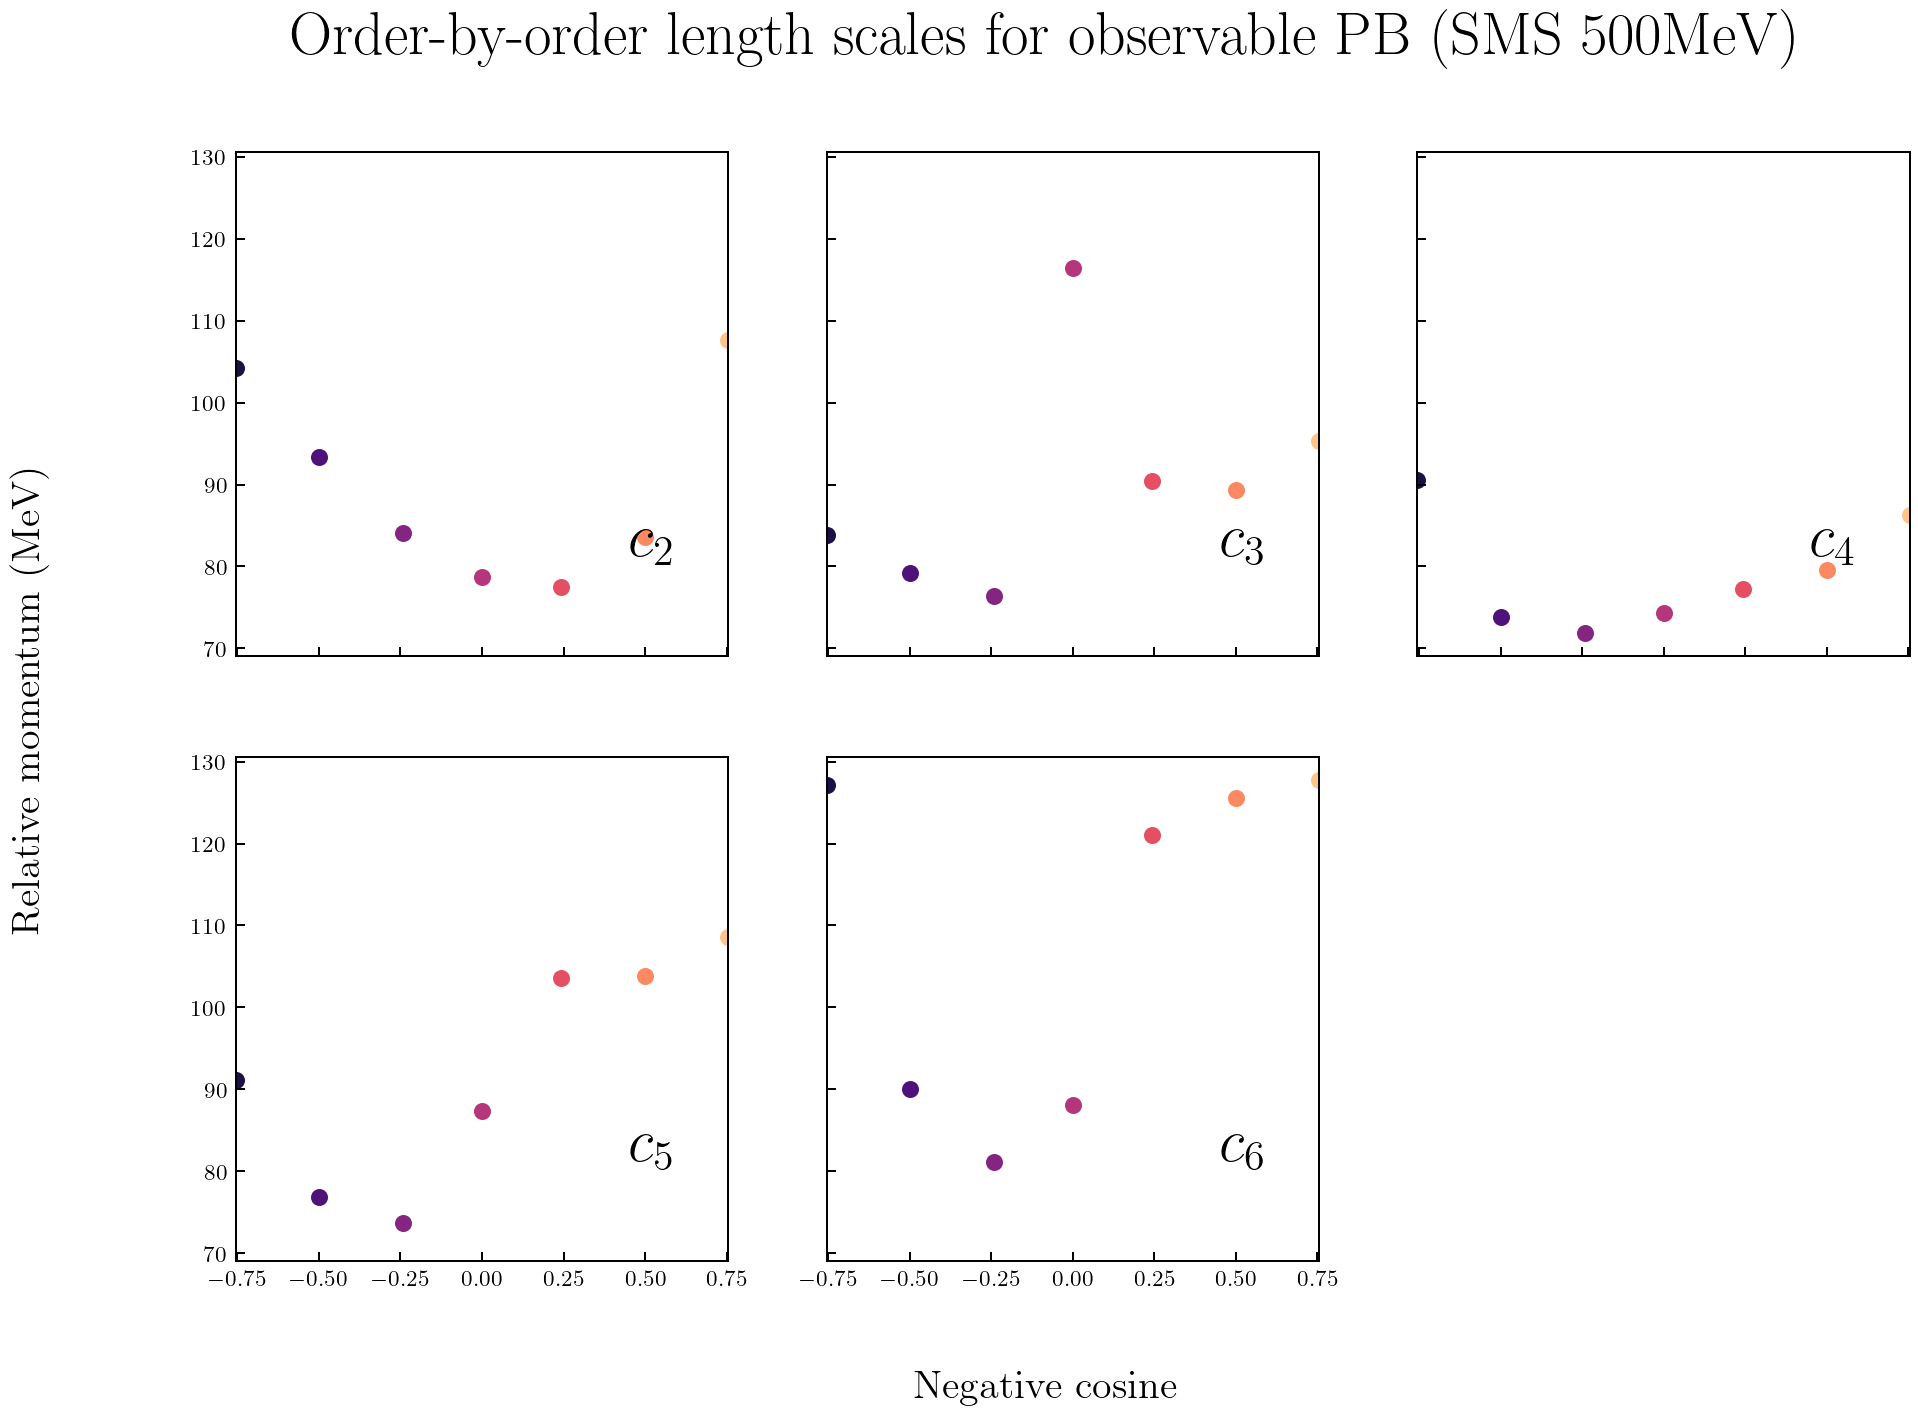

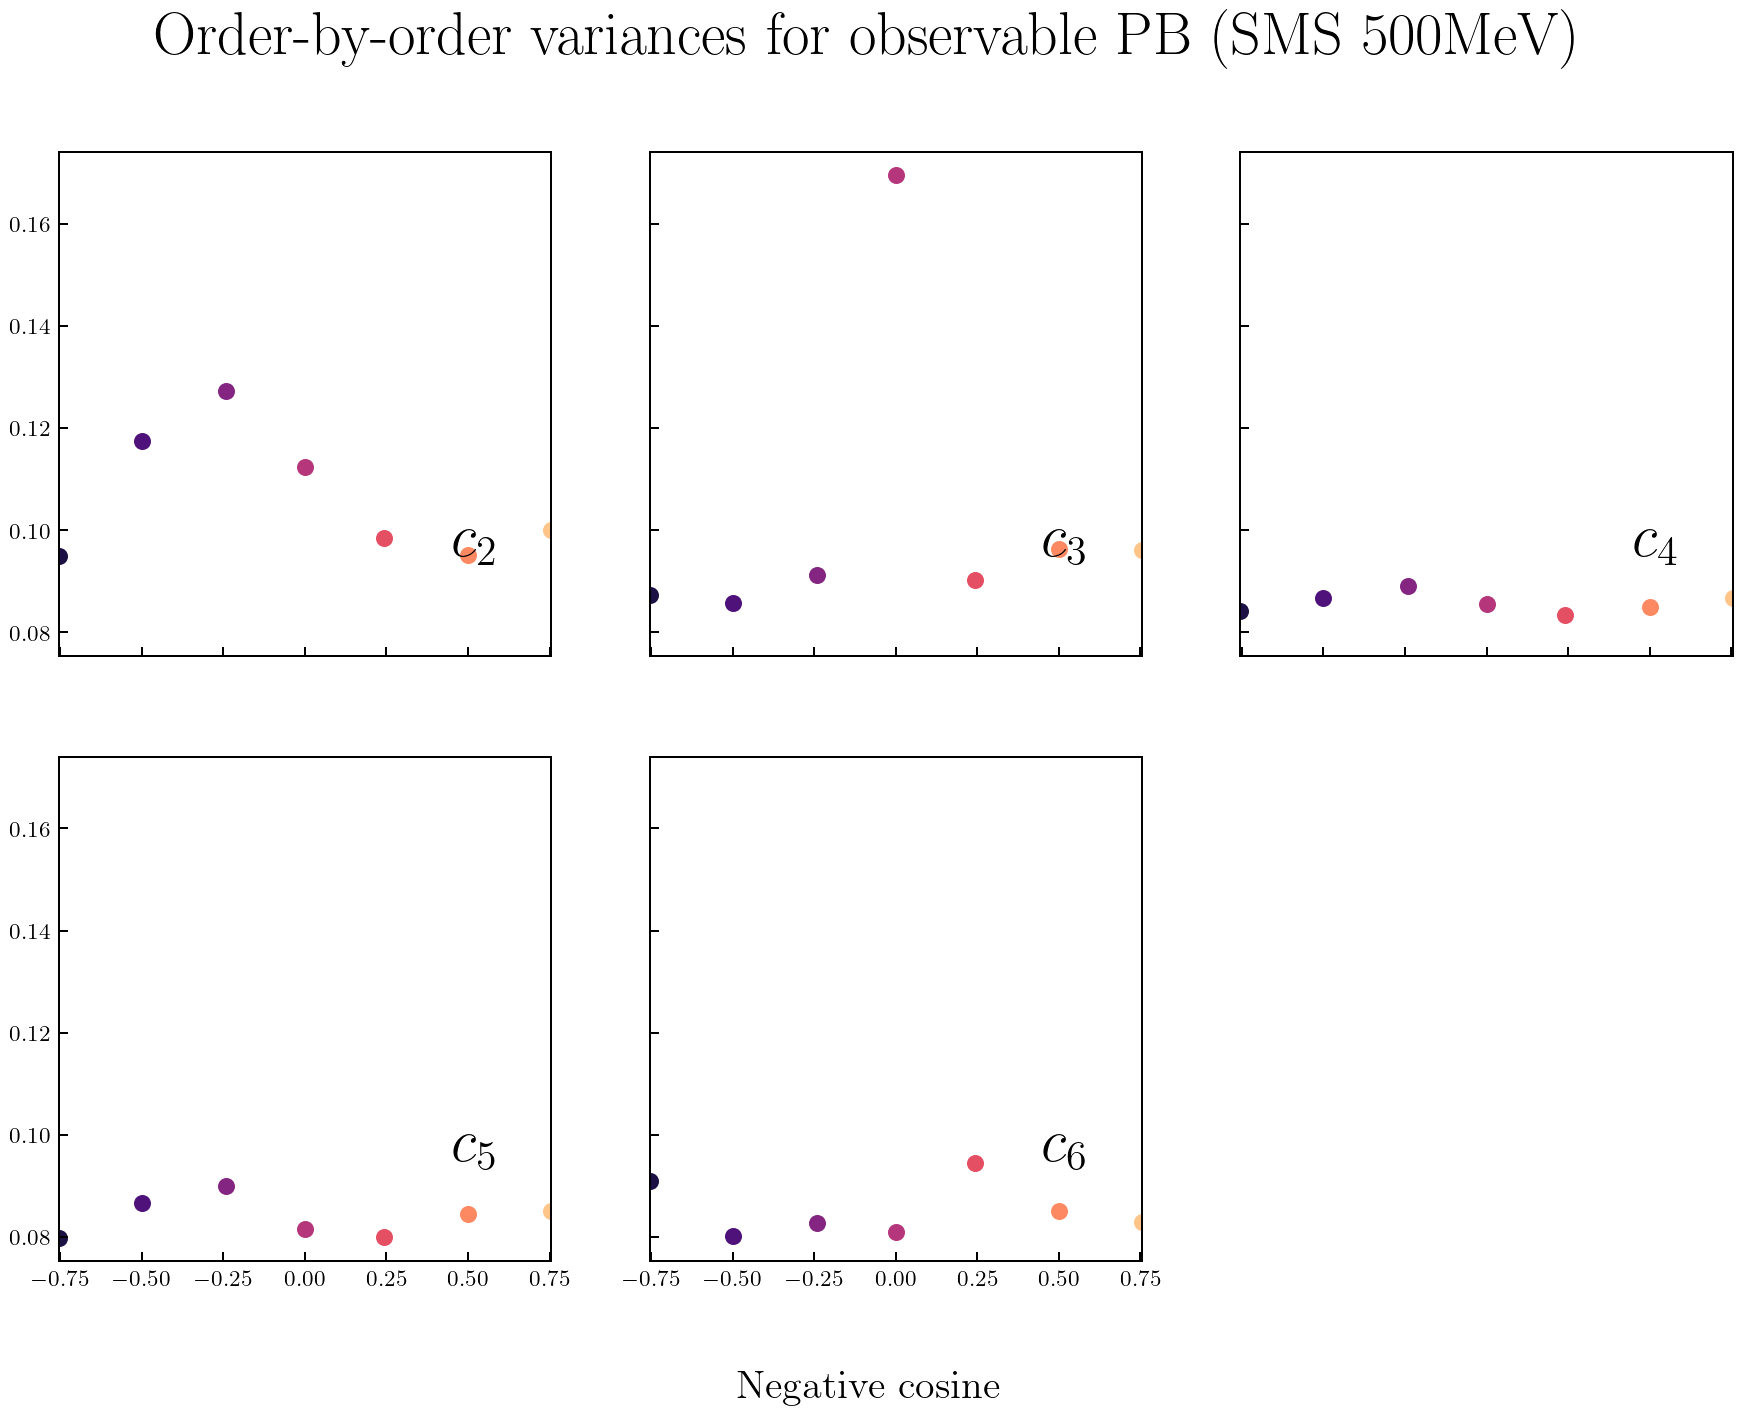

In [12]:
# choose colormap and fix to different energies
cmap_deg = mpl.cm.magma
norm_deg = mpl.colors.Normalize(vmin=np.min(degrees_input), vmax=np.max(degrees_input))

# create figure with n_orders subplots
fig_deg_coeffs, axs_deg_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_deg_coeffs.supxlabel(t_lab_label, size = 16)
fig_deg_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_deg_ls, axs_deg_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_deg_ls.supxlabel(degrees_label, size = 16)
fig_deg_ls.supylabel(t_lab_label, size = 16)
fig_deg_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# create figure with n_orders subplots
fig_deg_var, axs_deg_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(12, 8))
fig_deg_var.supxlabel(degrees_label, size = 16)
fig_deg_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)

# plots at each angle in mesh
for o in range(1, np.shape(coeffs_surfaces)[0]):
    (axs_deg_coeffs.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_coeffs.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_ls.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_ls.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_var.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_var.flat)[o - 1].transAxes, 
                       size = 24)
        
    for d in degrees_subset:
        (axs_deg_coeffs.flat)[o - 1].plot(t_lab_input, 
                    coeffs_surfaces[o, :, np.isin(degrees_input, d)].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_tlab, 
               (coeffs_surfaces[o, :, np.isin(degrees_input, d)].T)[np.isin(t_lab_input, X_train_tlab)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_deg_ls.flat)[o - 1].scatter(d, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_deg_var.flat)[o - 1].scatter(d, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

fig_deg_coeffs.delaxes(axs_deg_coeffs[-1, -1])        
fig_deg_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg), 
            ax = axs_deg_coeffs[-1, -1],
             orientation='horizontal', label=degrees_label)

fig_deg_ls.delaxes(axs_deg_ls[-1, -1])
fig_deg_var.delaxes(axs_deg_var[-1, -1])

# saves figures
fig_deg_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_deg_ls.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_deg_var.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')

#### Plots of lab-energy length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:891: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00026191]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 33, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\1283705784.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs_deg_ls_all.scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_6940\1283705784.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wit

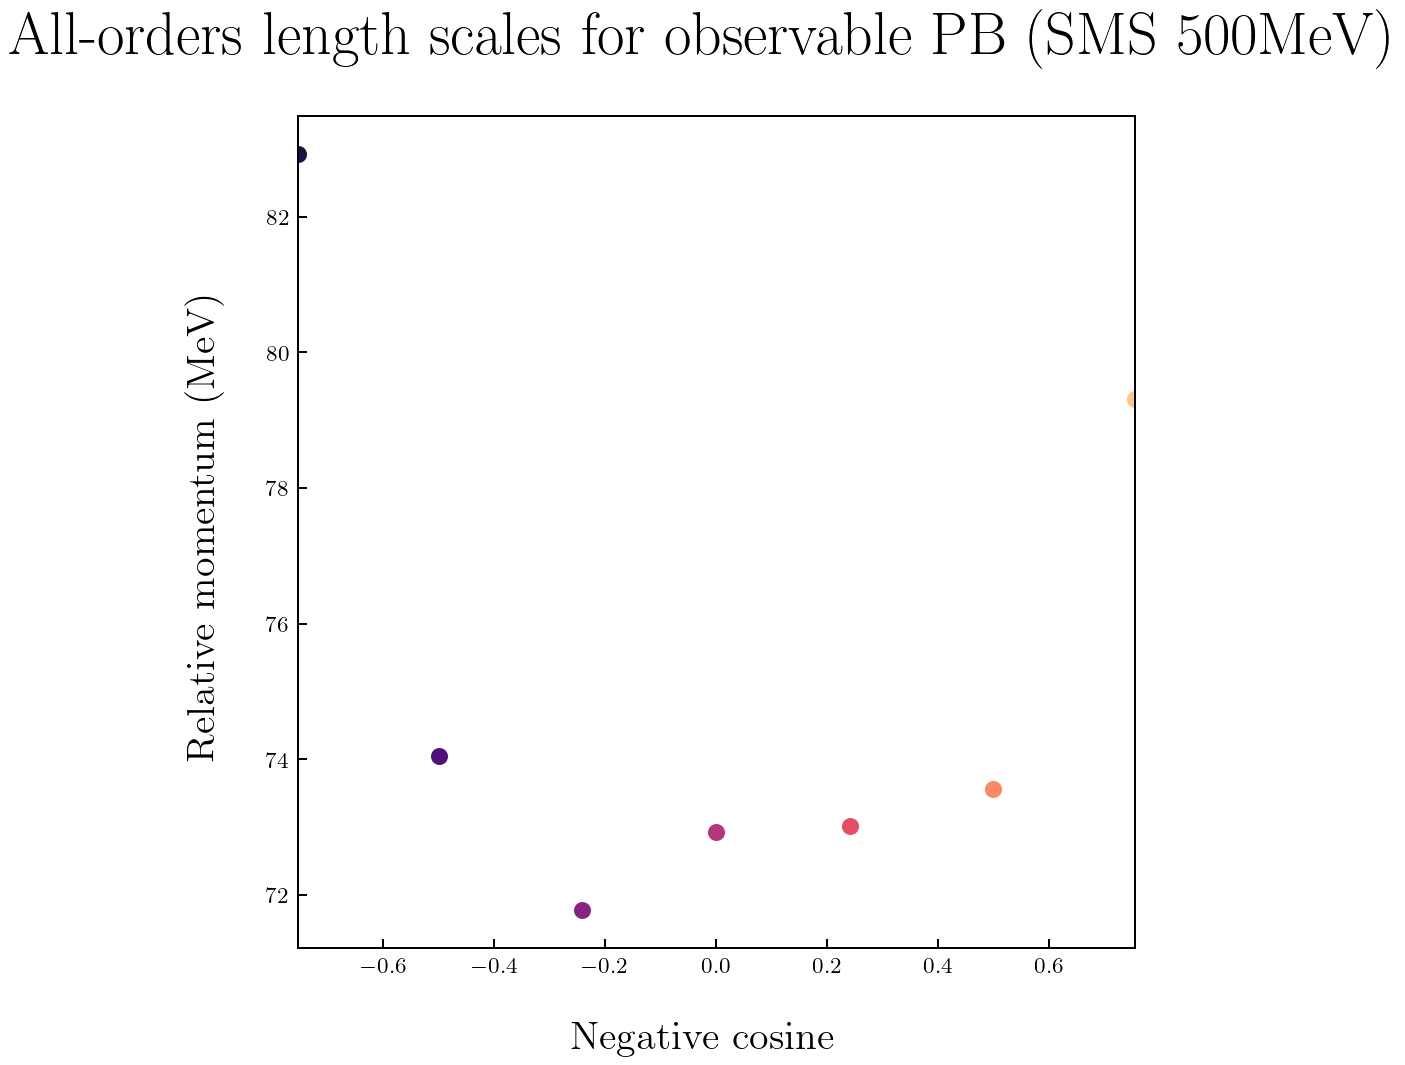

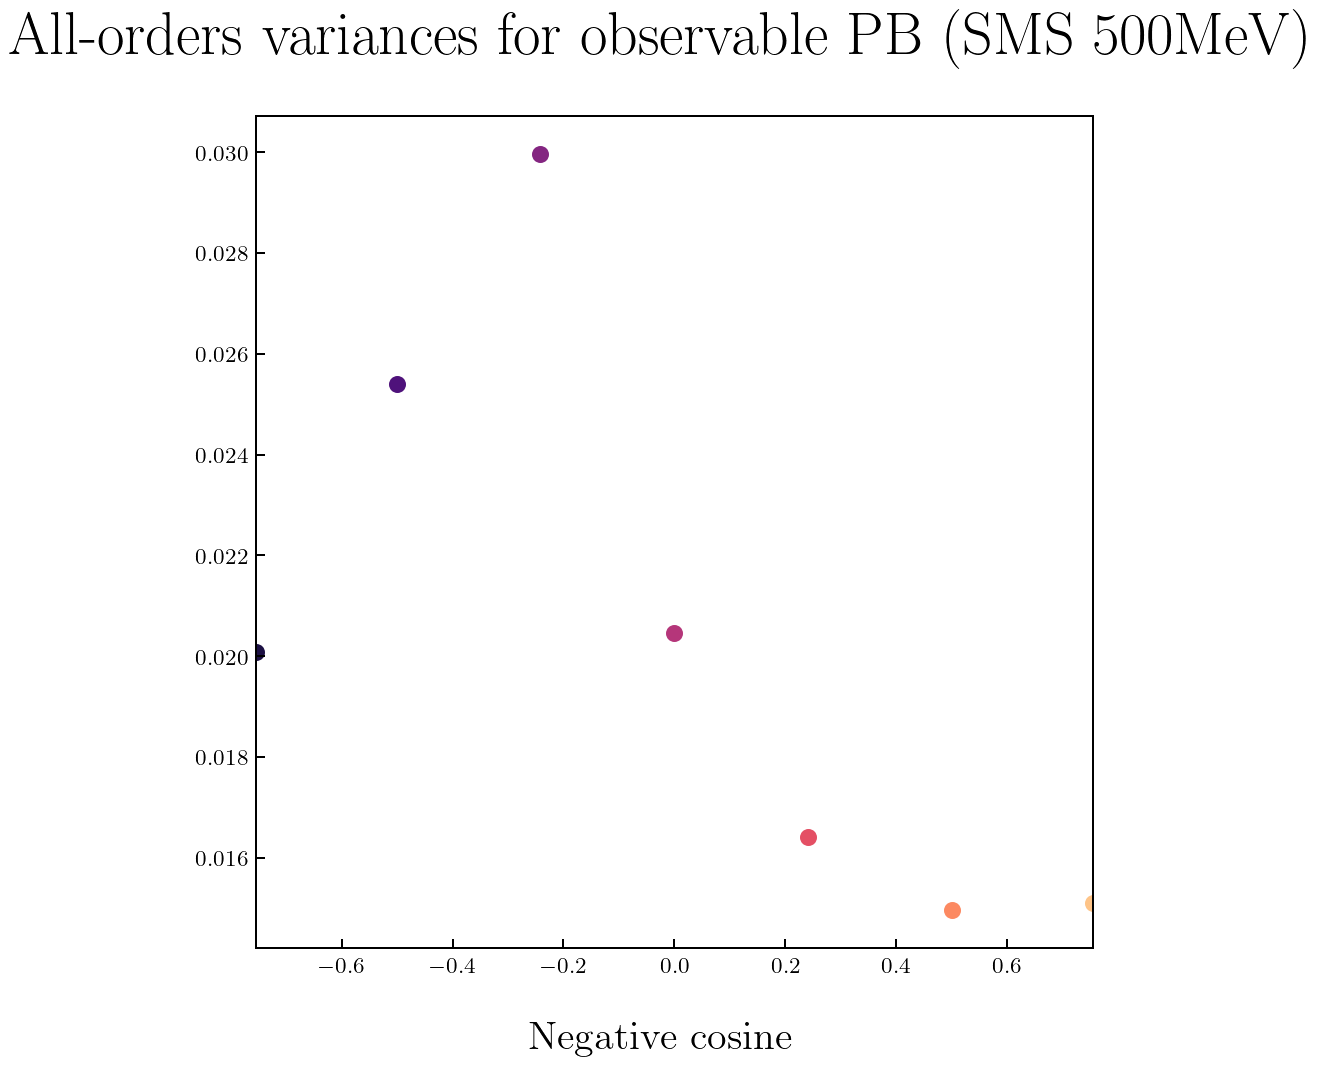

In [13]:
# create figure with n_orders subplots
fig_deg_ls_all, axs_deg_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_ls_all.supxlabel(degrees_label, size = 16)
fig_deg_ls_all.supylabel(t_lab_label, size = 16)
fig_deg_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_ls_all.semilogx()
# axs_deg_ls_all.semilogy()

# create figure with n_orders subplots
fig_deg_var_all, axs_deg_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_var_all.supxlabel(degrees_label, size = 16)
fig_deg_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_var_all.semilogx()
# axs_deg_var_all.semilogy()

# plots at each angle in mesh
for d in degrees_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=60,
                  length_scale_bounds=(12, 300)) + \
                  WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_tlab, 
           np.reshape(coeffs_surfaces[:, :, np.isin(degrees_input, d)].T, 
                     (len(t_lab), 
                     np.shape(coeffs_surfaces)[0]))[np.isin(t_lab_input, X_train_tlab), :])
    ls_fit = np.exp(gp.kernel_.theta)
    axs_deg_ls_all.scatter(d, 
                ls_fit, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

    pred, std = gp.predict(X_tlab, return_std=True)
    underlying_std = gp.cov_factor_
    axs_deg_var_all.scatter(d, 
                underlying_std, 
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

# saves figures
fig_deg_ls_all.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')
fig_deg_var_all.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + 'prel' + '_' + 
                    'degrees')